# XGBoosting/LGBM for EMS demand predictions


https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

Importing libraries

In [ ]:
# general routine set up:

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# get wd and change the wd plus import libraries
import os
os.getcwd()
#os.chdir("/Users/Manu/Dropbox/CBS MSc Thesis Research Folder/DATA & Code/Model Specific Notebooks")


# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from math import sqrt
import pickle

# ML
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import tensorflow.keras.backend as K
from lightgbm import LGBMRegressor

Loading the data

In [ ]:
## Way 1: mounting Google drive to import data directly from gdrive

# this allows for accessing files stored in your google drive using the path "/gdrive/"
# mounting google drive locally:

from google.colab import drive
drive.mount('/gdrive/')

Mounted at /gdrive/


In [ ]:
#loading the hourly traffic data from gdrive (1 year of data; June 2018 to June 2019)
filename = "/gdrive/My Drive/Colab Notebooks/emergency_dispatches_bronx_H"
infile = open(filename,'rb')
emergency_ts = pickle.load(infile)
infile.close()

In [ ]:
## Way 2: uploading the local data to google colab
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()

Saving emergency_dispatches_bronx_H to emergency_dispatches_bronx_H


In [ ]:
emergency_ts.shape

(8760,)

Preprocessing: already done


Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.  
There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

## Feature Engineering for Times Series

[feature_eng_ts.png](attachment:feature_eng_ts.png)

In this tutorial, we will look at three classes of features that we can create from our time series dataset:

    Date Time Features: these are components of the time step itself for each observation.
    Lag Features: these are values at prior time steps.
    Window Features: these are a summary of values over a fixed window of prior time steps.


Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.

**Preprocessing for Multioutput Forecasting**

### Preprocessing (For multi output model)
For supervised machine learning methods to work on time series it is necessary to do a certain amount of preprocessing. This includes feature generation such as embedding(lags). 

In [ ]:
## Remove last 15 days of data since they are either erroneous or part of the test set to the robustness checks
emergency_ts_final = emergency_ts.iloc[0:-360]
emergency_ts_final.shape

(8400,)

In [ ]:
## Set paramaters
data = emergency_ts_final.copy()
input_lags = 60 ## number of lags to be used for input. should be 2,5 times the seasonal period 
output_lags = 24 ## number of future oberservations to be forecasted
n_test = 24 ## size of test set 

In [ ]:
## Split data in train and test set
train = data[0:-n_test]
test = data[-n_test:]
print(train.shape)
print(test.shape)

(8376,)
(24,)


In [ ]:
## Create dataframe with the correct dimensions. Each row represents the past 54 observations and the 24 future observations
df = pd.DataFrame()
n_train = len(train)

## create inputs lags
for i in range(input_lags,0,-1):
    df['t-' + str(i)] = train.shift(i)

## create output lags
for j in range(0,output_lags,1):
    df['t+' + str(j)] = train.shift(-j)

## remove the first input_lags rows and last output_lags rows   
df = df[input_lags:(n_train-output_lags+1)]  

print(df.shape)

(8293, 84)


In [ ]:
## Split train into features X and targets Y
X_train = df.iloc[:,:input_lags] 
y_train = df.iloc[:,input_lags:]

## To create the test features X_test we cannot use any of the test set, since that includes the data held out
# for testing. We therefor use the last input_lags number of observations in the training set. These are however
# split between the targets and features and requires a combination of the two. (output_lags) from the targets 
# and (input_lags - output_lags) from the features
X_test = X_train.iloc[len(X_train) - 1,:][output_lags:] ## First get the last (input_lags - output_lags) from the features 
X_test = X_test.append(y_train.iloc[len(y_train) - 1,:]) ## Second, add the last (output_lags) from the targets

In [ ]:
## Remodel as numpy arrays and reshape
X_train_multi = X_train.values ## should be (n - input_lags - outputlags - n_test + 1) x (input_lags)
y_train_multi = y_train.values ## should be (n - input_lags - outputlags - n_test + 1) x (output_lags)
X_test_multi = X_test.values.reshape(1,input_lags) ## should be (1) x (input_lags) 
y_test_multi = test.values.reshape(1,n_test) ## should be (1) x (n_test)

print("X_train_multi: " + "type: " + str(type(X_train_multi)) + "\tshape: " + str(X_train_multi.shape))
print("y_train_multi: " + "type: " + str(type(y_train_multi)) + "\tshape: " + str(y_train_multi.shape))
print("X_test_multi: " + "type: " + str(type(X_test_multi)) + "\tshape: " + str(X_test_multi.shape))
print("y_test_multi: " + "type: " + str(type(y_test_multi)) + "\tshape: " + str(y_test_multi.shape))

X_train_multi: type: <class 'numpy.ndarray'>	shape: (8293, 60)
y_train_multi: type: <class 'numpy.ndarray'>	shape: (8293, 24)
X_test_multi: type: <class 'numpy.ndarray'>	shape: (1, 60)
y_test_multi: type: <class 'numpy.ndarray'>	shape: (1, 24)


$\textbf{General motivation for XG boosting}:$
One advantages of the XGBoosting algorithm is that it comes with the built in option to include regularization which is why it is also called a regularized boosting sometimes.
It also comes with a built in cross validation option and it provides plenty of flexiblities for parameter tuning. XGboosting makes splits up to the specified "max_depth" parameter and then prunes the trees backwards.
The iterative nature of this algorithm is also an advantage: one can build a new model based on the specification of the previous iteration, which has been implemented during the fine tuning of parameters in this case.

$\textbf{General setup of the algorithm}:$ As far as general parameters go, the booster "gbtree" has been used here, ie. I have been using tree based models in each iteration instead of a linear model, which is rarely used. I have started out with a number of estimators of 1,000 and then I have fine tuned the following parameters after try 2: max_depth and min_child_weight (gsearch1), reg_alpha (gsearch2), gamma (gsearch3), subsample and colsample_bytree (gsearch4), reg_lambda (gsearch5).  
I have used a feature importance plot of the XGBClassfier model to select the most important features to include. I have included the top 10 features out of the 24 features provided from try 3 onwards.
The fine tuned parameters have the following influence on the xg boosting algorithm:  
  
$\textit{max_depth:}$ specifies the max depth of a tree and can be used to control overfitting as higher depth will allow the model to learn relations very specific to a particular sample   
$\textit{min_child_weight:}$ this sets the minimum sum of weights of all observations required in a child. Higher values prevent the model from learning too specific relations.  
$\textit{reg_alpha:}$ L1 regularization term. Can be used in case of high dimensionality to make the algorithm run faster. Can be a solution to overfitting in case of a relatively small dataset.  
$\textit{gamma:}$ sets the minimum loss function required to make a split.  
$\textit{subsample:}$ sets the fraction of observations to be random samples of each tree. lower values prevent overfitting but small too small values might lead to underfitting.  
$\textit{colsample_bytree:}$ fraction of columns to be random samples of each tree.  
$\textit{reg_lambda:}$ L2 regularization term. can be a solution to overfitting in case of a relatively small dataset. Can be explored to reduce overfitting.

## XG (Extreme Gradient) boosting 

## Gridsearch CV

**Blogpost for XGB Hyperparameter tuning:**

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

**Full grid:**

xgbreg_cv = GridSearchCV(estimator = xgb_model, param_grid = {"colsample_bytree":[0.6,0.8,1.0], 'subsample':[0.8,1.0],"min_child_weight":[1.0,1.2], 'learning_rate': [0.1,0.05,0.01]
, 'max_depth': [5,8,10], 'n_estimators': [500,1000], 'lambda': [0.7,0.8,1], 'alpha':[0.7,0.8,1.0]}, verbose=1, cv = inner_loop, n_jobs=3)

**Gridsearch CV for the Multioutput XGB model**

In [ ]:
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train_multi,y_train_multi)

# lambda: l2(ridge) regularization term on weights, alpha: l1(lasso) regularization term on weights
# njobs: parallel processing -> speeds up the process a lot (assumption: quad core CPU -> n_jobs = 4)
# nthread set to -1 uses all the cores available in the system
xgb_model_multi = MultiOutputRegressor(xgb.XGBRegressor(objective = "reg:squarederror", booster='gbtree', nthread=-1))
xgbreg_cv_multi = GridSearchCV(estimator = xgb_model_multi, param_grid = {"estimator__colsample_bytree":[0.8,1.0], 'estimator__subsample':[0.8],"estimator__min_child_weight":[1,3,5], 'estimator__learning_rate': [0.1,0.05,0.01]
, 'estimator__max_depth': [5,8,10], 'estimator__n_estimators': [500,1000], 'estimator__lambda': [0.7,1.0], 'estimator__alpha':[0.7,1.0]}, verbose=1, cv = inner_loop, n_jobs=4)

Slightly reduced grid

In [ ]:
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train_multi,y_train_multi)

# lambda: l2(ridge) regularization term on weights, alpha: l1(lasso) regularization term on weights
# njobs: parallel processing -> speeds up the process a lot (assumption: quad core CPU -> n_jobs = 4)
# nthread set to -1 uses all the cores available in the system
xgb_model_multi = MultiOutputRegressor(xgb.XGBRegressor(objective = "reg:squarederror", booster='gbtree', nthread=-1))
xgbreg_cv_multi = GridSearchCV(estimator = xgb_model_multi, param_grid = {"estimator__colsample_bytree":[0.8,1.0], 'estimator__subsample':[0.8],"estimator__min_child_weight":[3,5], 'estimator__learning_rate': [0.1,0.05,0.01]
, 'estimator__max_depth': [5,8], 'estimator__n_estimators': [500], 'estimator__lambda': [0.7,1.0], 'estimator__alpha':[0.7,1.0]}, verbose=1, cv = inner_loop, n_jobs=4)

In [ ]:
xgbreg_cv_multi.fit(X_train_multi,y_train_multi)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 13.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 66.3min
[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed: 102.1min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fa907727150>,
             error_score=nan,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   gamma=0,
                                                                   importance_type='gain',
                                                                   learning_rate=0.1,
                                                                   max_delta_step=0,
                                                                   max_depth=3,
                                              

In [ ]:
# obtaining the best hyperparameter values from the gridsearch cv
xgbreg_cv_multi.best_params_

{'estimator__alpha': 0.7,
 'estimator__colsample_bytree': 0.8,
 'estimator__lambda': 0.7,
 'estimator__learning_rate': 0.05,
 'estimator__max_depth': 5,
 'estimator__min_child_weight': 5,
 'estimator__n_estimators': 500,
 'estimator__subsample': 0.8}

**Gridsearch CV results**

{'estimator__alpha': 0.7,
 'estimator__colsample_bytree': 0.8,
 'estimator__lambda': 0.7,
 'estimator__learning_rate': 0.05,
 'estimator__max_depth': 5,
 'estimator__min_child_weight': 5,
 'estimator__n_estimators': 500,
 'estimator__subsample': 0.8}
 

#LightGBM (Gradient Boosting)



https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

lightgbm parameters:

https://lightgbm.readthedocs.io/en/latest/Parameters.html


In [ ]:
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train_multi,y_train_multi)

# lambda: l2(ridge) regularization term on weights, alpha: l1(lasso) regularization term on weights 
# njobs: parallel processing -> speeds up the process a lot (assumption: quad core CPU -> n_jobs = 4)
# nthread set to -1 uses all the cores available in the system
lgbm_model_multi = MultiOutputRegressor(LGBMRegressor(boosting_type = "gbdt", objective = "root_mean_squared_error", n_jobs=-1,))
lgbm_cv_multi = GridSearchCV(estimator = lgbm_model_multi, param_grid = {"estimator__colsample_bytree":[0.8,1.0],'estimator__subsample':[1.0], 'estimator__learning_rate': [0.1,0.01]
, 'estimator__max_depth': [15,25], 'estimator__n_estimators': [150,250], 'estimator__reg_lambda': [0,0.7], 'estimator__reg_alpha':[0,0.7], 'estimator__num_leaves':[100,200], 'estimator__min_child_samples':[20]}, verbose=1, cv = inner_loop, n_jobs=-1)

In [ ]:
lgbm_cv_multi.fit(X_train_multi,y_train_multi) 

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 115.8min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe8798fef68>,
             error_score=nan,
             estimator=MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt',
                                                                    class_weight=None,
                                                                    colsample_bytree=1.0,
                                                                    importance_type='split',
                                                                    learning_rate=0.1,
                                                                    max_depth=-1,
                                                                    min_child_samples=20,
                                                                    min_child_weight=0.001,
                                                                    min_split_gain=0.0,
                                                                    n_estimators=100,
         

In [ ]:
# obtaining the best hyperparameter values from the gridsearch cv (Sep 11 2020)
## GRID: lgbm_model_multi = MultiOutputRegressor(LGBMRegressor(boosting_type = "gbdt", objective = "root_mean_squared_error", n_jobs=-1,))
##lgbm_cv_multi = GridSearchCV(estimator = lgbm_model_multi, param_grid = {"estimator__colsample_bytree":[0.8,1.0],'estimator__subsample':[1.0], 'estimator__learning_rate': [0.1,0.01]
## , 'estimator__max_depth': [15, 25], 'estimator__n_estimators': [150,250], 'estimator__reg_lambda': [0,0.7], 'estimator__reg_alpha':[0,0.7], 'estimator__num_leaves':[150,200], 'estimator__min_child_samples':[20]}, verbose=1, cv = inner_loop, n_jobs=-1)

lgbm_cv_multi.best_params_

In [ ]:
# obtaining the best hyperparameter values from the gridsearch cv (sep 03, 2020)
## GRID: lgbm_model_multi = MultiOutputRegressor(LGBMRegressor(boosting_type = "gbdt", objective = "root_mean_squared_error", n_jobs=-1,))
## lgbm_cv_multi = GridSearchCV(estimator = lgbm_model_multi, param_grid = {"estimator__colsample_bytree":[0.8,1.0],'estimator__subsample':[1.0], 'estimator__learning_rate': [0.1,0.01]
## , 'estimator__max_depth': [8,15], 'estimator__n_estimators': [100,250], 'estimator__reg_lambda': [0,0.7], 'estimator__reg_alpha':[0,0.7], 'estimator__num_leaves':[100,200], 'estimator__min_child_samples':[20]}, verbose=1, cv = inner_loop, n_jobs=-1)


lgbm_cv_multi.best_params_

{'estimator__colsample_bytree': 0.8,
 'estimator__learning_rate': 0.01,
 'estimator__max_depth': 15,
 'estimator__min_child_samples': 20,
 'estimator__n_estimators': 250,
 'estimator__num_leaves': 100,
 'estimator__reg_alpha': 0,
 'estimator__reg_lambda': 0,
 'estimator__subsample': 1.0}

#LightGBM optimal model


Sep 03 20: best model randomly found:

lgbm_reg_opt = LGBMRegressor(n_estimators=100, learning_rate= 0.1, num_leaves=200, min_child_samples=20, max_depth=8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=0.7, subsample=1.0, boosting_type = "gbdt", objective = "root_mean_squared_error")

RMSE: 5.708364462095884


In [ ]:
#lgbm_reg_opt=LGBMRegressor(random_state=1,learning_rate=0.001, objective = "root_mean_squared_error", n_estimators = 500, colsample_bytree = 1, max_depth = -1, subsample= 1.0, min_child_weight = 10, reg_lambda = 1, reg_alpha= 1.0, eval_metric = "rmse")
lgbm_reg_opt = LGBMRegressor(n_estimators=250, learning_rate= 0.01, num_leaves=150, min_child_samples=20, max_depth=15, colsample_bytree=0.8, reg_alpha=0, reg_lambda=0, subsample=1.0, boosting_type = "gbdt", objective = "root_mean_squared_error")

# Fitting a Multioutputregressor xgb model to obtain multioutput forecasts

lgbm_moreg_fit = MultiOutputRegressor(lgbm_reg_opt).fit(X_train_multi, y_train_multi)

In [ ]:
# running the retrained model on the test data to obtain predictions
lgbm_preds_multi = lgbm_moreg_fit.predict(X_test_multi)
lgbm_preds_multi.shape

(1, 24)

In [ ]:
# optimal model based on the new grid from Sep 11
lgbm_reg_2 = LGBMRegressor(n_estimators=250, learning_rate= 0.01, num_leaves=150, min_child_samples=20, max_depth=25, colsample_bytree=0.8, reg_alpha=0, reg_lambda=0, subsample=1.0, boosting_type = "gbdt", objective = "root_mean_squared_error")


# Fitting a Multioutputregressor xgb model to obtain multioutput forecasts 

lgbm_reg_2_fit = MultiOutputRegressor(lgbm_reg_2).fit(X_train_multi, y_train_multi)

In [ ]:
# running the retrained model on the test data to obtain predictions
lgbm_preds_2 = lgbm_reg_2_fit.predict(X_test_multi)
lgbm_preds_2.shape

(1, 24)

#Quantile Regression loss function for Prediction intervals

Way 1 (lightgbm)


In [ ]:
# Fitting the optimal PI model for the upper PI bound (alpha = 0.975 & quantile loss)

alpha = 0.975

lgbm_reg_pi=LGBMRegressor(random_state=1,learning_rate=0.1, objective = "quantile", n_estimators =500, num_leaves=30, min_child_samples=20, colsample_bytree = 0.8, max_depth = 5, subsample= 1.0, min_child_weight =8, reg_lambda = 0.7, reg_alpha= 0, alpha=alpha, eval_metric = "rmse")


lgbm_reg_fit_upper = MultiOutputRegressor(lgbm_reg_pi).fit(X_train_multi, y_train_multi)

# Make the prediction on the meshed x-axis
y_upper = lgbm_reg_fit_upper.predict(X_test_multi)

In [ ]:
# Fitting the optimal PI model for the lower PI bound (alpha = 0.025 & quantile loss)

alpha = 0.025

lgbm_reg_pi=LGBMRegressor(random_state=1,learning_rate=0.1, objective = "quantile", n_estimators =500, num_leaves=30, min_child_samples=20, colsample_bytree = 0.8, max_depth = 5, subsample= 1.0, min_child_weight =8, reg_lambda = 0.7, reg_alpha= 0, alpha=alpha, eval_metric = "rmse")


lgbm_reg_fit_lower = MultiOutputRegressor(lgbm_reg_pi).fit(X_train_multi, y_train_multi)

# Make the prediction on the meshed x-axis
y_lower = lgbm_reg_fit_lower.predict(X_test_multi)

Way 2

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b

In [ ]:
from functools import partial

In [ ]:
class XGBQuantile(xgb.XGBRegressor):
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, eval_metric = "rmse", max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
    
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )
    
    return np.array(split_gain)

In [ ]:
# setting up parameters for the PI
#quant_alpha = 0.95,quant_delta= 5.0, quant_thres = 5.0 ,quant_var=4.0


xgb_reg_pi=XGBQuantile(random_state=1,learning_rate=0.05, objective = "reg:squarederror", n_estimators =500, colsample_bytree = 0.8, max_depth = 5, subsample= 0.8, min_child_weight =5, reg_lambda = 0.7, reg_alpha=0.7, eval_metric = "rmse", quant_alpha = 0.95,quant_delta= 2500.0, quant_thres = 5000.0 ,quant_var=4000.0
)

## Fitting a single output regressor xgb model
#xgb_reg_opt.fit(X_train, y_train)

# Fitting a Multioutputregressor xgb model to obtain multioutput forecasts

xgb_reg_pi_fit = MultiOutputRegressor(xgb_reg_pi).fit(X_train_multi, y_train_multi)


In [ ]:
xgb_reg_pi_fit.predict(X_test_multi)

array([[ -611.7996 ,   340.96817,  3036.0671 ,  1227.5073 ,  4619.9453 ,
         3447.534  ,  1064.8623 ,  5258.358  ,   591.29224,  5505.0566 ,
        -2702.347  , -1129.5913 ,  -183.88712,  5604.364  ,  2617.0684 ,
        -4991.2114 ,  3502.5667 , -3391.7332 ,  1052.6561 ,  -962.0054 ,
         2150.9321 , -2320.031  ,   707.97064,   648.9829 ]],
      dtype=float32)

## Obtaining predictions

**Multi-output model**

LIGHTGBM

In [ ]:
# running the retrained model on the test data
lgbm_preds_multi = lgbm_moreg_fit.predict(X_test_multi)
lgbm_preds_multi.shape

(1, 24)

In [ ]:
# MSE
mse_lgbm_multi = mean_squared_error(y_test_multi, lgbm_preds_multi)
mse_lgbm_multi

41.95403556336665

In [ ]:
# RMSE
sqrt(mse_lgbm_multi)

6.477193494359008

In [ ]:
# MAE
mean_absolute_error(y_test_multi, lgbm_preds_multi)

5.450748794202223

In [ ]:
# custom MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = y_test_multi
y_pred = lgbm_preds_multi

In [ ]:
# MAPE
mean_absolute_percentage_error(y_true,y_pred)

15.175408968195308

**Plotting the predictions**

LIGHTGBM

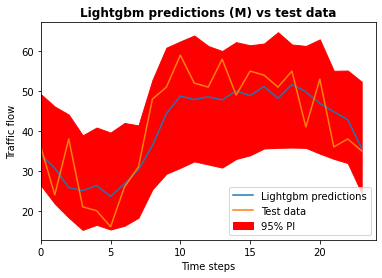

In [ ]:
# plotting the predictions

plt.xlim(0,24)
#plt.ylim(0,18000)
# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("Lightgbm predictions (M) vs test data", fontweight="bold")
plt.fill_between(x = np.arange(0,24), y1= np.transpose(y_lower).reshape(24), y2=np.transpose(y_upper).reshape(24), color = "r")


plt.plot(np.transpose(lgbm_preds_multi), label="Lightgbm_predictions (M)")
plt.plot(np.transpose(y_test_multi), label = "Test data")
legend = plt.legend(["Lightgbm predictions","Test data", "95% PI"],loc='lower right')




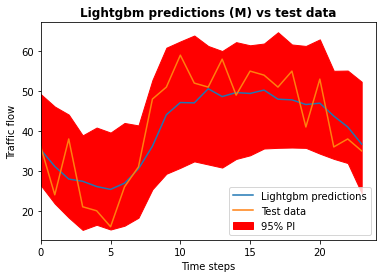

In [ ]:
# plotting the predictions

plt.xlim(0,24)
#plt.ylim(0,18000)
# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("Lightgbm predictions (M) vs test data", fontweight="bold")
plt.fill_between(x = np.arange(0,24), y1= np.transpose(y_lower).reshape(24), y2=np.transpose(y_upper).reshape(24), color = "r")


plt.plot(np.transpose(lgbm_preds_multi), label="Lightgbm_predictions (M)")
plt.plot(np.transpose(y_test_multi), label = "Test data")
legend = plt.legend(["Lightgbm predictions","Test data", "95% PI"],loc='lower right')

**Exporting the Data as a CSV file:**


In [ ]:


# Creating a dataframe with GRU predictions and test data
LGBM_ems_df = pd.DataFrame(np.transpose(lgbm_preds_multi))

# adding a column with the test data
LGBM_ems_df["PI upper bound"] = np.transpose(y_upper)
LGBM_ems_df["PI lower bound"] = np.transpose(y_lower)
LGBM_ems_df["Test data"] = np.transpose(y_test_multi)


LGBM_ems_df.columns = ['LGBM predictions', "PI upper bound", "PI lower bound", 'Test data']

In [ ]:
LGBM_ems_df

,LGBM predictions,PI upper bound,PI lower bound,Test data
0,34.027028,49.225207,26.361475,36
1,30.700403,46.121314,21.796601,24
2,25.807636,44.112620,18.286224,38
3,25.050276,38.902421,15.198752,21
4,26.312824,40.854777,16.484056,20
5,23.604465,39.596867,15.300044,16
6,26.796239,42.009419,16.245893,26
7,30.304896,41.393579,18.259384,31
8,36.346763,52.770832,25.384382,48
9,44.368607,60.872869,29.278359,51


In [ ]:
# saving the dataframe as a CSV file to google drive
#LGBM_ems_df.to_csv('/gdrive/My Drive/Colab Notebooks/LGBM_ems_preds.csv', index=False)

# saving the dataframe as a csv file and downloading it to the local drive
from google.colab import files
LGBM_ems_df.to_csv('LGBM_ems_df.csv') 
files.download('LGBM_ems_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>